## Problem Description

The EMC Data Science Global Hackathon dataset, or the ‘Air Quality Prediction‘ dataset for short, describes weather conditions at multiple sites and requires a prediction of air quality measurements over the subsequent three days.

## Load Dataset

In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import os
print(os.listdir("../input"))
# load dataset
dataset = pd.read_csv('../input/TrainingData.csv', header=0)

['SiteLocations_with_more_sites.csv', 'sample_code.r', 'SubmissionZerosExceptNAs.csv', 'TrainingData.csv', 'SiteLocations.csv']


In [5]:
dataset.head()

,rowID,chunkID,position_within_chunk,month_most_common,weekday,hour,Solar.radiation_64,WindDirection..Resultant_1,WindDirection..Resultant_1018,WindSpeed..Resultant_1,WindSpeed..Resultant_1018,Ambient.Max.Temperature_14,Ambient.Max.Temperature_22,Ambient.Max.Temperature_50,Ambient.Max.Temperature_52,Ambient.Max.Temperature_57,Ambient.Max.Temperature_76,Ambient.Max.Temperature_2001,Ambient.Max.Temperature_3301,Ambient.Max.Temperature_6005,Ambient.Min.Temperature_14,Ambient.Min.Temperature_22,Ambient.Min.Temperature_50,Ambient.Min.Temperature_52,Ambient.Min.Temperature_57,Ambient.Min.Temperature_76,Ambient.Min.Temperature_2001,Ambient.Min.Temperature_3301,Ambient.Min.Temperature_6005,Sample.Baro.Pressure_14,Sample.Baro.Pressure_22,Sample.Baro.Pressure_50,Sample.Baro.Pressure_52,Sample.Baro.Pressure_57,Sample.Baro.Pressure_76,Sample.Baro.Pressure_2001,Sample.Baro.Pressure_3301,Sample.Baro.Pressure_6005,Sample.Max.Baro.Pressure_14,Sample.Max.Baro.Pressure_22,...,Sample.Min.Baro.Pressure_6005,target_1_57,target_10_4002,target_10_8003,target_11_1,target_11_32,target_11_50,target_11_64,target_11_1003,target_11_1601,target_11_4002,target_11_8003,target_14_4002,target_14_8003,target_15_57,target_2_57,target_3_1,target_3_50,target_3_57,target_3_1601,target_3_4002,target_3_6006,target_4_1,target_4_50,target_4_57,target_4_1018,target_4_1601,target_4_2001,target_4_4002,target_4_4101,target_4_6006,target_4_8003,target_5_6006,target_7_57,target_8_57,target_8_4002,target_8_6004,target_8_8003,target_9_4002,target_9_8003
0,1,1,1,10,Saturday,21,0.01,117.0,187.0,0.3,0.3,NaN,NaN,NaN,14.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,747.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.679233,6.181623,NaN,0.114975,0.114975,0.114975,0.114975,0.114975,0.114975,0.114975,NaN,2.389656,NaN,5.568154,0.690015,NaN,NaN,NaN,NaN,NaN,NaN,2.843490,0.092022,1.693211,0.368089,0.184045,0.368089,0.276067,0.892617,1.748424,NaN,NaN,5.130631,1.341606,2.138792,3.013752,NaN,5.679280,NaN
1,2,1,2,10,Saturday,22,0.01,231.0,202.0,0.5,0.6,NaN,NaN,NaN,14.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,747.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.679233,8.475833,NaN,0.114975,0.114975,0.114975,0.114975,0.114975,0.114975,0.114975,NaN,1.991380,NaN,5.568154,0.923260,NaN,NaN,NaN,NaN,NaN,NaN,3.101153,0.092022,1.941671,0.368089,0.184045,0.368089,0.368089,1.739222,2.144120,NaN,NaN,5.130631,1.195779,2.722099,3.888712,NaN,7.426751,NaN
2,3,1,3,10,Saturday,23,0.01,247.0,227.0,0.5,1.5,NaN,NaN,NaN,14.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,747.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.679233,8.921930,NaN,0.114975,0.114975,0.114975,0.114975,0.114975,0.114975,0.114975,NaN,1.752415,NaN,5.568154,0.680297,NaN,NaN,NaN,NaN,NaN,NaN,3.064344,0.092022,2.521412,0.460112,0.184045,0.368089,0.368089,1.785233,1.932469,NaN,NaN,5.136395,1.409658,3.110970,3.888712,NaN,7.683732,NaN
3,4,1,4,10,Sunday,0,0.01,219.0,218.0,0.2,1.2,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,751.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.679233,5.098246,NaN,0.114975,0.114975,0.114975,0.114975,0.114975,0.114975,0.114975,NaN,2.389656,NaN,5.677619,0.612267,NaN,NaN,NaN,NaN,NaN,NaN,3.211580,0.184045,2.374176,0.460112,0.184045,0.368089,0.276067,1.868053,2.088907,NaN,NaN,5.217102,1.477711,2.041574,3.208188,NaN,4.831243,NaN
4,5,1,5,10,Sunday,1,0.01,2.0,216.0,0.2,0.3,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,751.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.679233,4.875197,NaN,0.114975,0.114975,0.114975,0.114975,0.114975,0.114975,0.114975,NaN,2.310001,NaN,5.677619,0.694875,NaN,NaN,NaN,NaN,NaN,NaN,3.671691,0.184045,2.466199,0.460112,0.184045,0.368089,0.276067,1.702413,2.604232,NaN,NaN,5.217102,1.458267,2.138792,3.499841,NaN,4.625658,NaN


In [6]:
dataset.tail()

,rowID,chunkID,position_within_chunk,month_most_common,weekday,hour,Solar.radiation_64,WindDirection..Resultant_1,WindDirection..Resultant_1018,WindSpeed..Resultant_1,WindSpeed..Resultant_1018,Ambient.Max.Temperature_14,Ambient.Max.Temperature_22,Ambient.Max.Temperature_50,Ambient.Max.Temperature_52,Ambient.Max.Temperature_57,Ambient.Max.Temperature_76,Ambient.Max.Temperature_2001,Ambient.Max.Temperature_3301,Ambient.Max.Temperature_6005,Ambient.Min.Temperature_14,Ambient.Min.Temperature_22,Ambient.Min.Temperature_50,Ambient.Min.Temperature_52,Ambient.Min.Temperature_57,Ambient.Min.Temperature_76,Ambient.Min.Temperature_2001,Ambient.Min.Temperature_3301,Ambient.Min.Temperature_6005,Sample.Baro.Pressure_14,Sample.Baro.Pressure_22,Sample.Baro.Pressure_50,Sample.Baro.Pressure_52,Sample.Baro.Pressure_57,Sample.Baro.Pressure_76,Sample.Baro.Pressure_2001,Sample.Baro.Pressure_3301,Sample.Baro.Pressure_6005,Sample.Max.Baro.Pressure_14,Sample.Max.Baro.Pressure_22,...,Sample.Min.Baro.Pressure_6005,target_1_57,target_10_4002,target_10_8003,target_11_1,target_11_32,target_11_50,target_11_64,target_11_1003,target_11_1601,target_11_4002,target_11_8003,target_14_4002,target_14_8003,target_15_57,target_2_57,target_3_1,target_3_50,target_3_57,target_3_1601,target_3_4002,target_3_6006,target_4_1,target_4_50,target_4_57,target_4_1018,target_4_1601,target_4_2001,target_4_4002,target_4_4101,target_4_6006,target_4_8003,target_5_6006,target_7_57,target_8_57,target_8_4002,target_8_6004,target_8_8003,target_9_4002,target_9_8003
37816,55364,210,188,8,Wednesday,4,0.01,35.0,NaN,0.5,NaN,NaN,NaN,23.0,27.7,24.6,23.5,23.6,30.1,26.8,NaN,NaN,17.7,17.0,18.3,18.9,18.3,16.4,18.5,NaN,NaN,741.0,747.0,751.0,750.0,743.0,751.0,746.0,NaN,NaN,...,742.0,NaN,0.095592,NaN,0.919801,1.782115,NaN,1.609652,1.322214,0.114975,0.574876,NaN,1.752415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.371133,0.092022,1.343526,NaN,0.092022,NaN,0.092022,NaN,1.453953,NaN,0.933143,NaN,NaN,0.291653,0.291653,NaN,0.642453,NaN
37817,55365,210,189,8,Wednesday,5,0.01,41.0,NaN,0.5,NaN,NaN,NaN,23.0,27.7,24.6,23.5,23.6,30.1,26.8,NaN,NaN,17.7,17.0,18.3,18.9,18.3,16.4,18.5,NaN,NaN,741.0,747.0,751.0,750.0,743.0,751.0,746.0,NaN,NaN,...,742.0,NaN,0.350504,NaN,0.804826,1.724628,NaN,1.379702,0.747339,0.114975,0.114975,NaN,2.230346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.104268,0.092022,1.591986,NaN,0.184045,NaN,0.092022,NaN,1.076661,NaN,0.599878,NaN,NaN,0.291653,0.291653,NaN,1.002226,NaN
37818,55366,210,190,8,Wednesday,6,0.04,90.0,NaN,1.6,NaN,NaN,NaN,23.0,27.7,24.6,23.5,23.6,30.1,26.8,NaN,NaN,17.7,17.0,18.3,18.9,18.3,16.4,18.5,NaN,NaN,741.0,747.0,751.0,750.0,743.0,751.0,746.0,NaN,NaN,...,742.0,NaN,0.254912,NaN,0.689851,1.609652,NaN,NaN,0.632363,0.114975,0.287438,NaN,1.911725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.647200,0.092022,1.601189,NaN,0.184045,NaN,0.184045,NaN,1.113470,NaN,0.599878,NaN,NaN,0.291653,0.291653,NaN,0.822339,NaN
37819,55367,210,191,8,Wednesday,7,0.14,35.0,NaN,0.8,NaN,NaN,NaN,23.0,27.7,24.6,23.5,23.6,30.1,26.8,NaN,NaN,17.7,17.0,18.3,18.9,18.3,16.4,18.5,NaN,NaN,741.0,747.0,751.0,750.0,743.0,751.0,746.0,NaN,NaN,...,742.0,NaN,0.286776,NaN,0.459901,NaN,NaN,1.092264,0.919801,0.114975,0.459901,NaN,1.513449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.223897,0.000000,2.328165,NaN,0.184045,NaN,0.184045,NaN,1.058257,NaN,0.666531,NaN,NaN,0.291653,0.291653,NaN,0.719547,NaN
37820,55368,210,192,8,Wednesday,8,0.48,38.0,NaN,3.5,NaN,NaN,NaN,23.0,27.7,24.6,23.5,23.6,30.1,26.8,NaN,NaN,17.7,17.0,18.3,18.9,18.3,16.4,18.5,NaN,NaN,741.0,747.0,751.0,750.0,743.0,751.0,746.0,NaN,NaN,...,742.0,NaN,0.159320,NaN,0.862314,1.034777,NaN,0.977289,1.322214,0.402413,0.632363,NaN,0.876207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.297515,0.000000,1.748424,NaN,0.276067,NaN,0.092022,NaN,1.573582,NaN,1.266409,NaN,NaN,0.291653,0.291653,NaN,0.436868,NaN


In [11]:
dataset.shape

(37821, 95)

In [7]:
# trim and transform to floats
values = dataset.values
data = values[:, 6:].astype('float32')

In [10]:
# summarize amount of missing data
total_missing = np.count_nonzero(np.isnan(data))
percent_missing = total_missing / data.size * 100
print('Total Missing: %d/%d (%.1f%%)' % (total_missing, data.size, percent_missing))

Total Missing: 1922092/3366069 (57.1%)


## Chunk Data Structure

In [14]:
# split data into chunks
# split the dataset by 'chunkID', return a dict of id to rows
def to_chunks(values, chunk_ix=1):
    chunks = dict()
    # get the unique chunk ids
    chunk_ids = np.unique(values[:, chunk_ix])
    # group rows by chunk id
    for chunk_id in chunk_ids:
        selection = values[:, chunk_ix] == chunk_id
        chunks[chunk_id] = values[selection, :]
    return chunks

In [15]:
# plot distribution of chunk durations
def plot_chunk_durations(chunks):
    # chunk durations in hours
    chunk_durations = [len(v) for k,v in chunks.items()]
    # boxplot
    plt.subplot(2, 1, 1)
    plt.boxplot(chunk_durations)
    # histogram
    plt.subplot(2, 1, 2)
    plt.hist(chunk_durations)
    # histogram
    plt.show()

In [16]:
# group data by chunks
values = dataset.values
chunks = to_chunks(values)
print('Total Chunks: %d' % len(chunks))

Total Chunks: 208


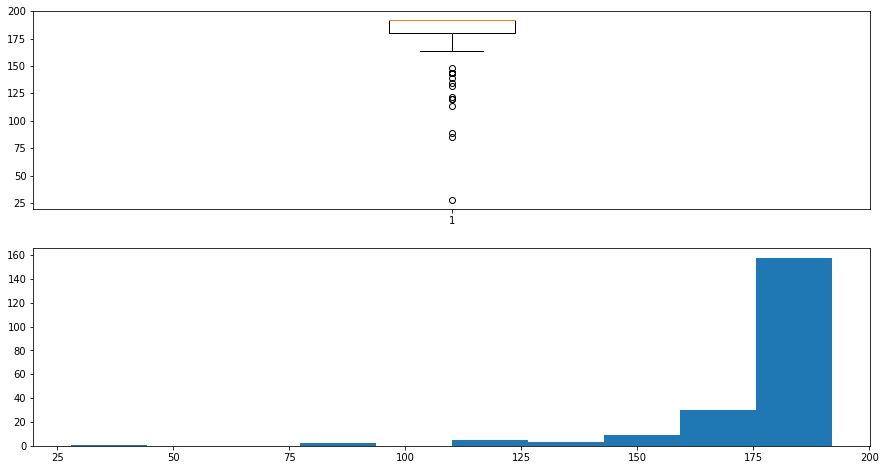

In [25]:
plt.figure(figsize=(15,8))
# plot chunk durations
plot_chunk_durations(chunks)

## Chunk Contiguousness

In [21]:
# plot chunks that do not have all data
def plot_discontiguous_chunks(chunks, row_in_chunk_ix=2):
    n_steps = 8 * 24
    for c_id,rows in chunks.items():
        # skip chunks with all data
        if rows.shape[0] == n_steps:
            continue
        # create empty series
        series = [np.nan for _ in range(n_steps)]
        # mark all rows with data
        for row in rows:
            # convert to zero offset
            r_id = row[row_in_chunk_ix] - 1
            # mark value
            series[r_id] = c_id
            # plot
        plt.plot(series)
    plt.show()

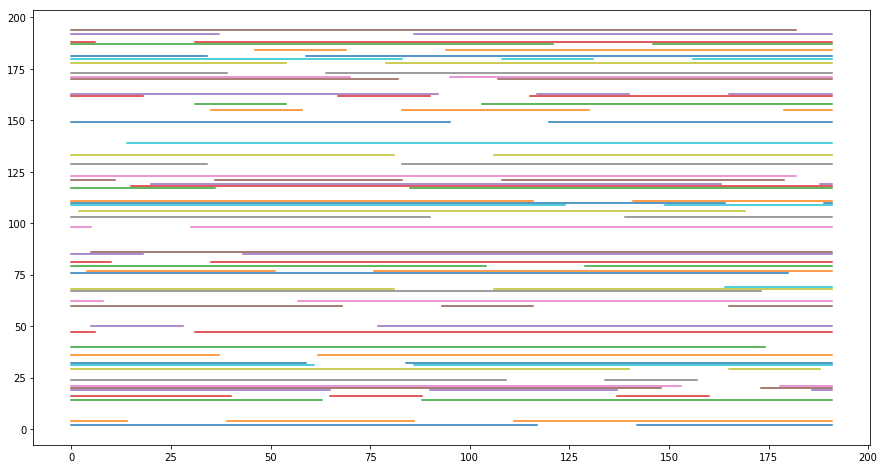

In [24]:
# group data by chunks
values = dataset.values
chunks = to_chunks(values)
# plot discontiguous chunks
plt.figure(figsize=(15,8))
plot_discontiguous_chunks(chunks)

## Daily Coverage Within Chunks

The discontiguous nature of the chunks also suggests that it may be important to look at the hours covered by each chunk.

In [26]:
# plot distribution of chunk start hour
def plot_chunk_start_hour(chunks, hour_in_chunk_ix=5):
    # chunk start hour
    chunk_start_hours = [v[0, hour_in_chunk_ix] for k,v in chunks.items() if len(v)==192]
    # boxplot
    plt.subplot(2, 1, 1)
    plt.boxplot(chunk_start_hours)
    # histogram
    plt.subplot(2, 1, 2)
    plt.hist(chunk_start_hours, bins=24)
    # histogram
    plt.show()

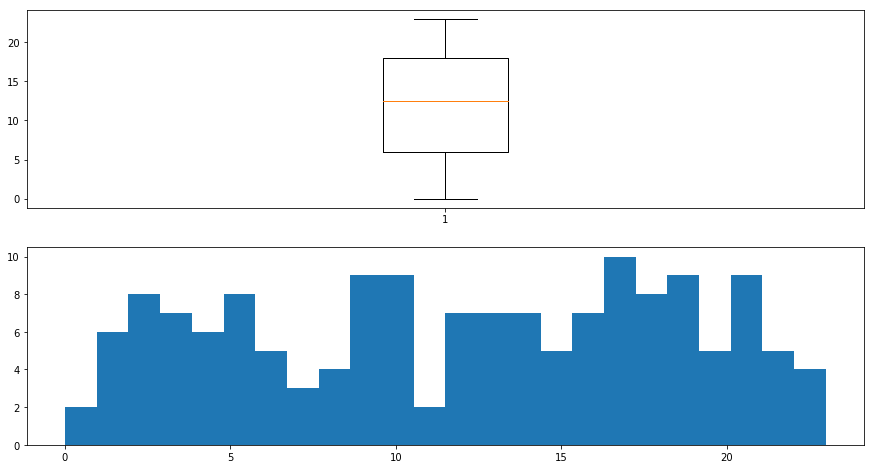

In [27]:
# group data by chunks
values = dataset.values
chunks = to_chunks(values)
# plot distribution of chunk start hour
plt.figure(figsize=(15,8))
plot_chunk_start_hour(chunks)

## Temporal Structure of Inputs for a Chunk

In [31]:
# plot all inputs for one or more chunk ids
def plot_chunk_inputs(chunks, c_ids):
    plt.figure(figsize=(15,8))
    inputs = range(6, 56)
    for i in range(len(inputs)):
        ax = plt.subplot(len(inputs), 1, i+1)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        column = inputs[i]
        for chunk_id in c_ids:
            rows = chunks[chunk_id]
            plt.plot(rows[:,column])
    plt.show()

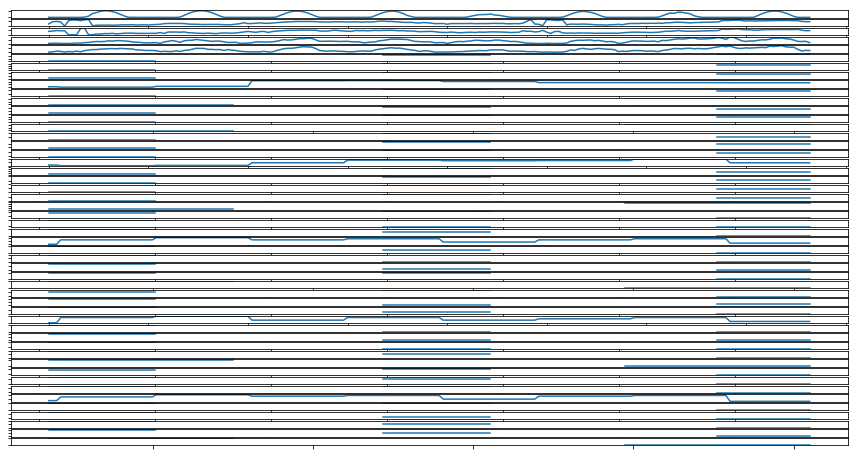

In [32]:
# group data by chunks
values = dataset.values
chunks = to_chunks(values)
# plot inputs for some chunks
plot_chunk_inputs(chunks, [1])

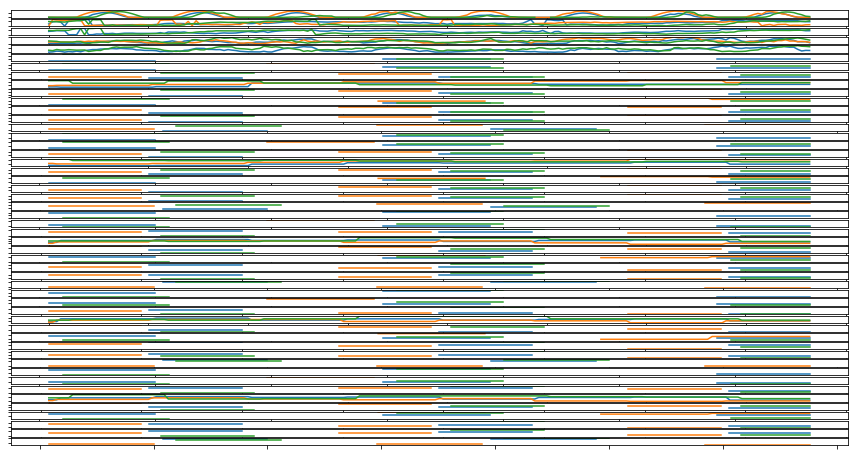

In [33]:
plot_chunk_inputs(chunks, [1, 3 ,5])

## Input Data Distribution

Let's look at the distribution of input variables crudely using box and whisker plots.

In [34]:
# boxplot for input variables for a chuck
def plot_chunk_input_boxplots(chunks, c_id):
    rows = chunks[c_id]
    plt.boxplot(rows[:,6:56])
    plt.show()

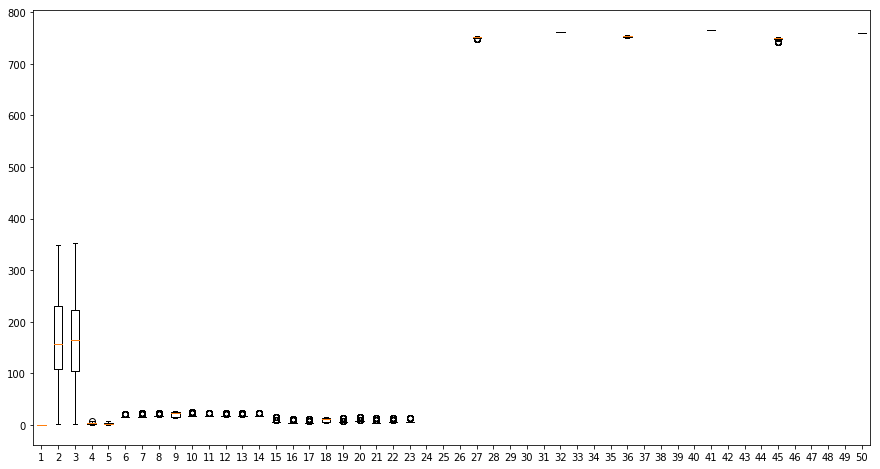

In [35]:
# group data by chunks
values = dataset.values
chunks = to_chunks(values)
# boxplot for input variables
plt.figure(figsize=(15,8))
plot_chunk_input_boxplots(chunks, 1)

## Temporal Structure of Targets for a Chunk

In [38]:
# plot all targets for one or more chunk ids
def plot_chunk_targets(chunks, c_ids):
    plt.figure(figsize=(15,8))
    targets = range(56, 95)
    for i in range(len(targets)):
        ax = plt.subplot(len(targets), 1, i+1)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        column = targets[i]
        for chunk_id in c_ids:
            rows = chunks[chunk_id]
            plt.plot(rows[:,column])
    plt.show()
    

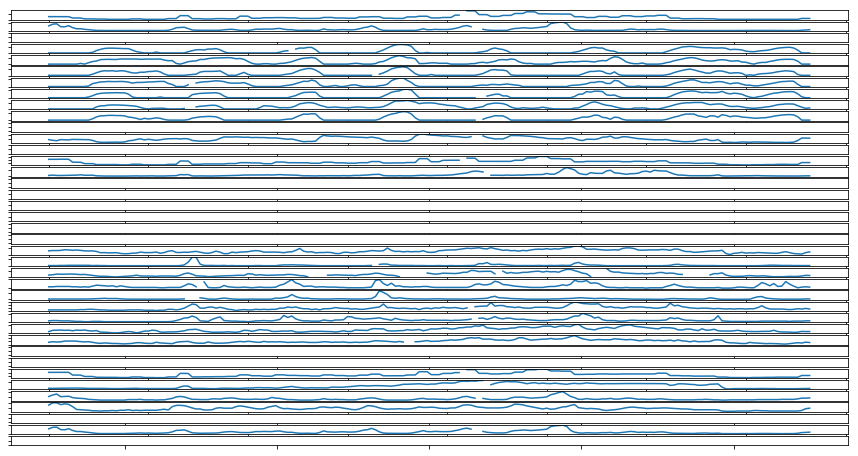

In [39]:
# group data by chunks
values = dataset.values
chunks = to_chunks(values)
# plot targets for some chunks
plot_chunk_targets(chunks, [1])

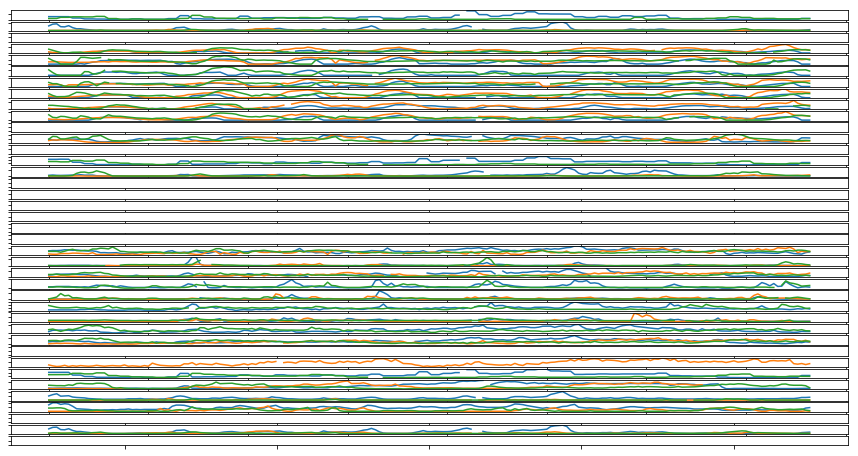

In [41]:
# plot targets for some chunks
plot_chunk_targets(chunks, [1, 3 ,5])

## Boxplot Distribution of Target Variables

In [42]:
# boxplot for target variables for a chuck
def plot_chunk_targets_boxplots(chunks, c_id):
    rows = chunks[c_id]
    plt.boxplot(rows[:,56:])
    plt.show()

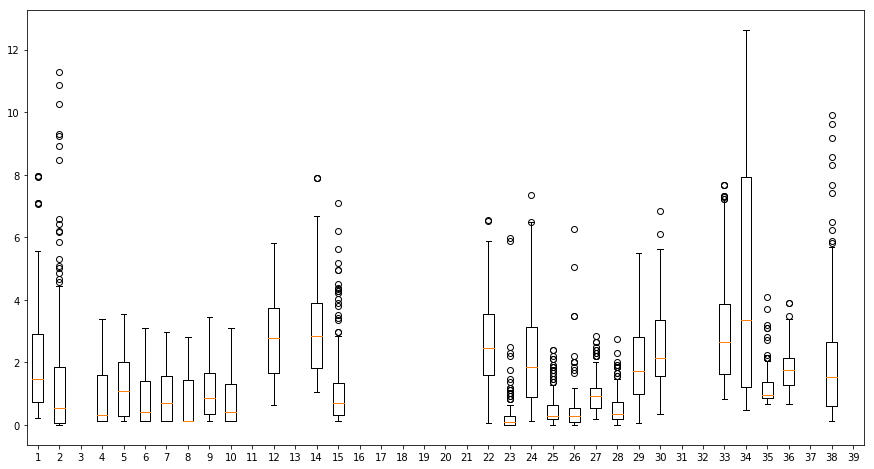

In [44]:
# group data by chunks
values = dataset.values
chunks = to_chunks(values)
# boxplot for target variables
plt.figure(figsize=(15,8))
plot_chunk_targets_boxplots(chunks, 1)

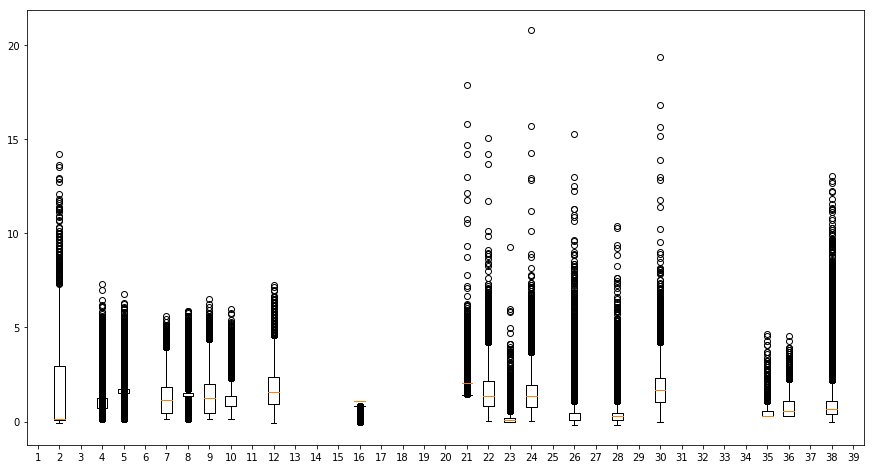

In [45]:
# boxplot for all target variables
def plot_target_boxplots(values):
    plt.boxplot(values[:,56:])
    plt.show()
# boxplot for target variables
values = dataset.values
plt.figure(figsize=(15,8))
plot_target_boxplots(values)

## Apparently Empty Target Columns

In [46]:
# bar chart of the ratio of missing data per column
def plot_col_percentage_missing(values, ix_start=5):
    ratios = list()
    # skip early columns, with meta data or strings
    for col in range(ix_start, values.shape[1]):
        col_data = values[:, col].astype('float32')
        ratio = np.count_nonzero(np.isnan(col_data)) / len(col_data) * 100
        ratios.append(ratio)
        if ratio > 90.0:
            print(ratio)
    col_id = [x for x in range(ix_start, values.shape[1])]
    plt.bar(col_id, ratios)
    plt.show()

91.48885539779488
91.48885539779488
91.48885539779488
91.48885539779488
91.48885539779488
95.38880516115385
96.9805134713519
95.38880516115385
97.31630575606145
95.38880516115385
95.38880516115385
95.38880516115385


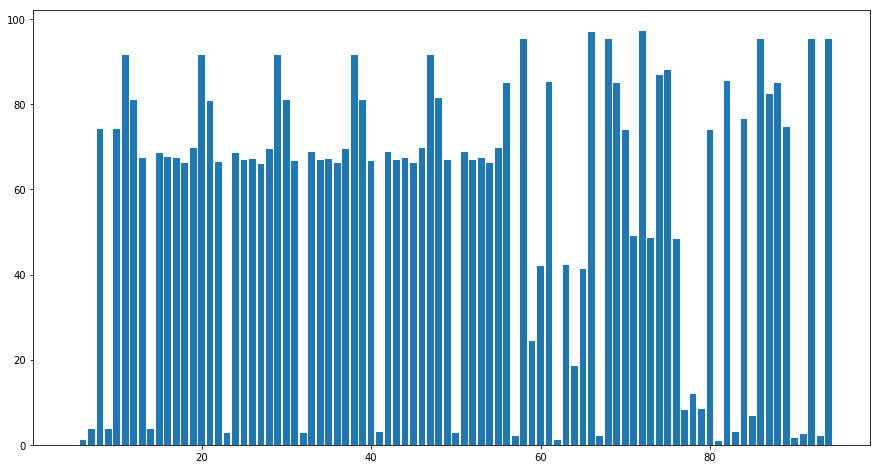

In [47]:
# plot ratio of missing data per column
values = dataset.values
plt.figure(figsize=(15,8))
plot_col_percentage_missing(values)

## Histogram Distribution of Target Variables

In [48]:
# plot distribution of targets for one or more chunk ids
def plot_chunk_targets_hist(chunks, c_ids):
    plt.figure(figsize=(15,8))
    targets = range(56, 95)
    for i in range(len(targets)):
        ax = plt.subplot(len(targets), 1, i+1)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        column = targets[i]
        for chunk_id in c_ids:
            rows = chunks[chunk_id]
            # extract column of interest
            col = rows[:,column].astype('float32')
            # check for some data to plot
            if np.count_nonzero(np.isnan(col)) < len(rows):
                # only plot non-nan values
                plt.hist(col[~np.isnan(col)], bins=100)
    plt.show()

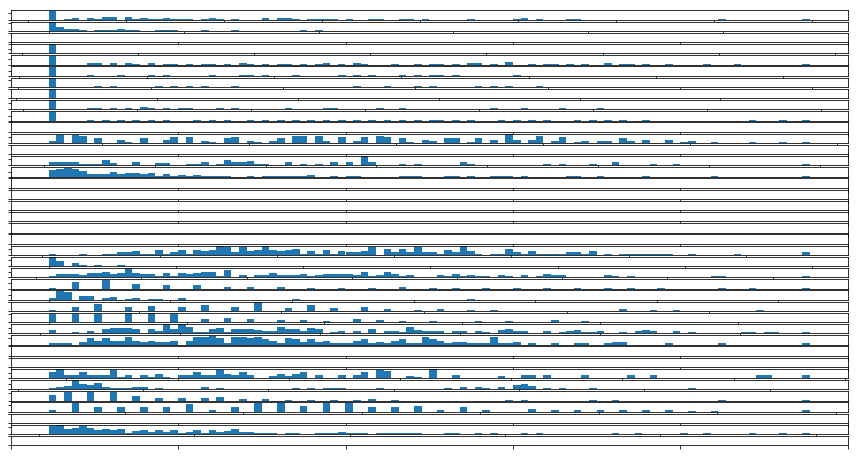

In [49]:
# group data by chunks
values = dataset.values
chunks = to_chunks(values)
# plot targets for some chunks
plot_chunk_targets_hist(chunks, [1])

1. Reference: [machinelearningmastery.com](https://machinelearningmastery.com/how-to-load-visualize-and-explore-a-complex-multivariate-multistep-time-series-forecasting-dataset/)